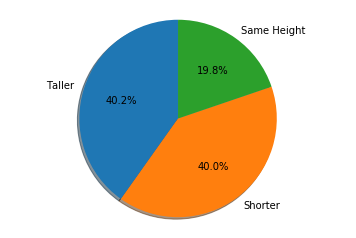

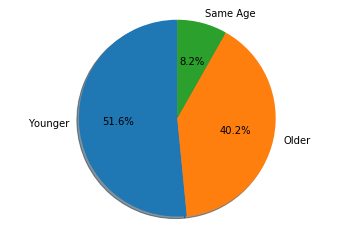

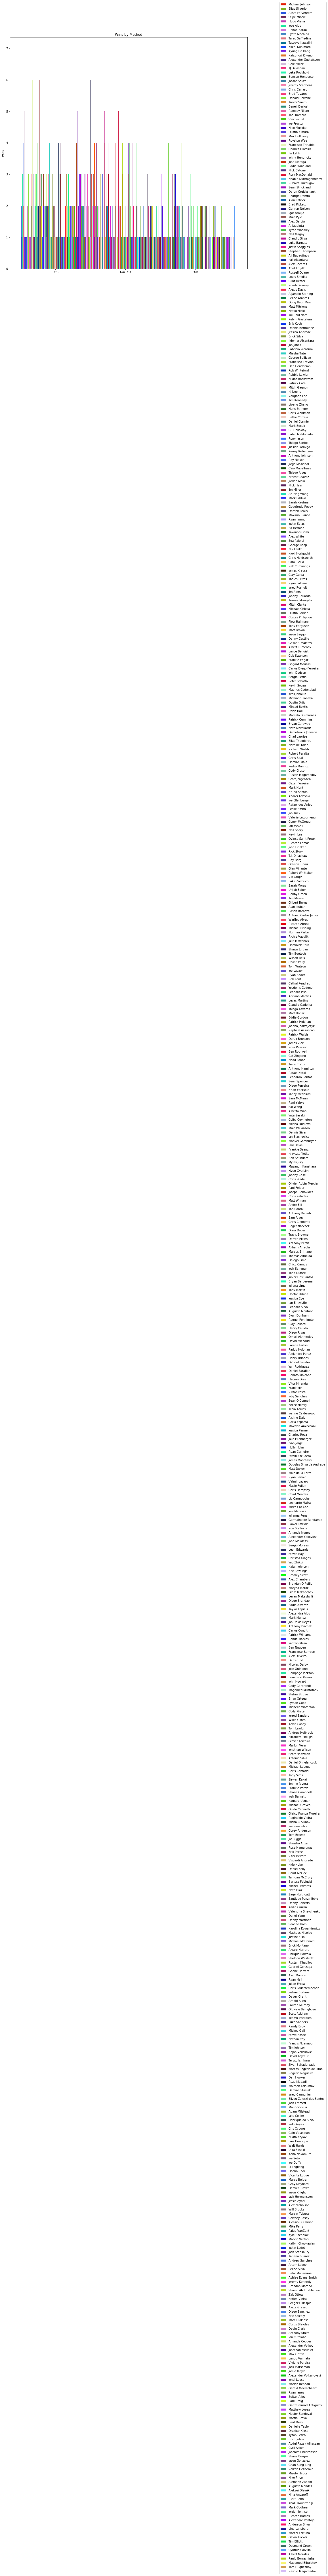

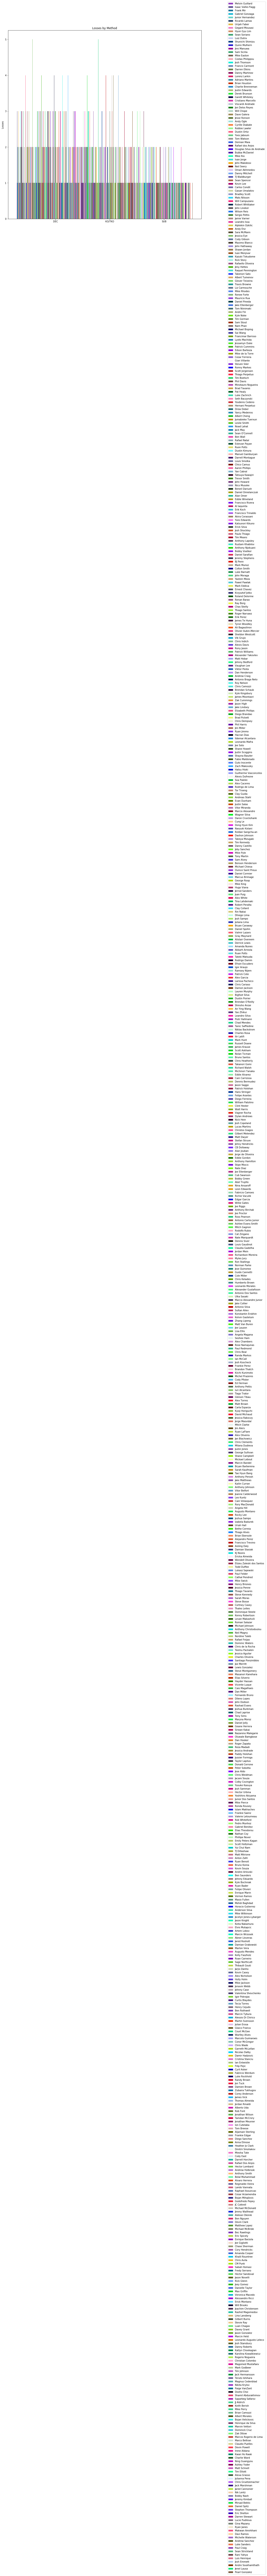

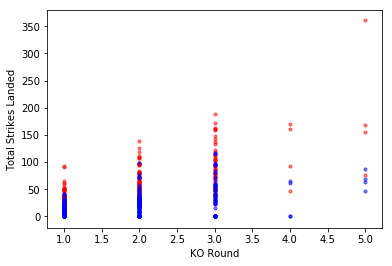

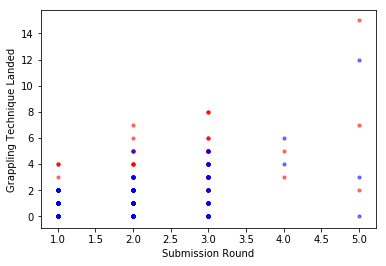



##########  Random Fighter Matchup  ##########
Fighter 1 name: Rony Jason
Fighter 1 points: 5.0
Fighter 2 name: Lisa Ellis
Fighter 2 points: 0.0
Winner: Rony Jason


In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import random


class UFCData(object):
    '''
    Class for parsing and performing calculations on the UFC data set
    '''
    
    def __init__(self, filename):
        self.ufc_data = pd.read_csv(filename)
        self.win_types = {'DEC': 0, 'KO/TKO': 0, 'SUB': 0}
        
    @property
    def ufc_data(self):
        '''
        Property for ufc_data
        @return: the instance's pandas Dataframe        
        '''
        
        return self._ufc_data
    
    @ufc_data.setter
    def ufc_data(self, data):
        '''
        This setter method will drop unneeded columns from the data set
        @param data: A pandas Dataframe from a read-in csv file
        @type data: pandas.Dataframe
        '''
        
        # List of known named columns that must be dropped. Some fight round columns will be dropped later
        columns_to_drop = ['Date', 'Event_ID', 'Max_round', 'RStreak', 'HomeTown', 'Location', 'Weight']
        
        # Drop afformentioned columns
        data = data.drop(columns=columns_to_drop)

        # Now we have many columns of round data. The only columns that we want to keep are either strikes landed or submissions
        # landed. Which means we have to drop every column that doesn't have a label which matches this pattern:
        # 'Round * _Landed'
        for i in data.columns.values:
            # Check if this is a Round columnn:
            if i.startswith('Round'):
                # If the column describes a landed technique, keep it. Otherwise drop it
                if i.endswith('Landed'):
                    pass

                else:
                    data = data.drop(i, axis=1)

        # To simplyfy the data set further, I'm only keeping the 'Round N Total Strikes Landed' columns
        for i in data.columns.values:
            # Check if this is a strikes column
            if 'Strikes' in i:
                # If this is the total strikes landed column, keep it. Otherwise drop it
                if i.endswith('_Strikes_Total Strikes_Landed'):
                    pass

                else:
                    data = data.drop(i, axis=1)

        # Since I'm also comparing wins and losses, I will have to remove the 'draw' and 'no contest' fights to simplify things
        for index, row in data.iterrows():
            # Check if fight is a draw or no contest, if so remove the record
            if row.loc['winner'] == 'draw' or row.loc['winner'] == 'no contest':
                data = data.drop(index)
        
        # Set the trimmed data set to the main data
        self._ufc_data = data
    
    def columns(func):
        '''
        Wrapper function to get all the columns index locations. 
        This is for convenience when using the get winners and get_losers functions
        @param func: The function to wrap
        @type func: a function
        @return: wrapper function
        '''
        
        def func_wrapper(self):
            # Get column numbers for height and age
            height_col = self.ufc_data.columns.get_loc('Height')
            age_col = self.ufc_data.columns.get_loc('Age')
            fight_id_col = self.ufc_data.columns.get_loc('Fight_ID')
            corner_col = self.ufc_data.columns.get_loc('corner')
            winner_col = self.ufc_data.columns.get_loc('winner')
            name_col = self.ufc_data.columns.get_loc('Name')
            winby_col = self.ufc_data.columns.get_loc('winby')
            last_round_col = self.ufc_data.columns.get_loc('Last_round')
            
            return func(self, height_col=height_col, age_col=age_col, fight_id_col=fight_id_col, 
                        corner_col=corner_col, winner_col=winner_col, name_col=name_col, winby_col=winby_col,
                       last_round_col=last_round_col)
        return func_wrapper
    
    @columns    
    def get_all_winners_by_win_type(self, **kwargs):
        '''
        Gets all fighters by win type in a key-value map, where the key is the fighters name, and the value is 
        a tuple of three numbers representing their wins by decision, ko/tko, and submission
        @return: A key value dict of fighter name, and win total type tuple.
        '''
        
        # Get all the winners
        winners = self.get_winners()
        # Create a map to hold the fighter - win type tuple key / value mapping
        all_fighters = {}
        
        # Reset win types
        self.win_types = {'DEC': 0, 'KO/TKO': 0, 'SUB': 0}
        
        # Loop through the array of winners and tally win types for each fighter
        for winner in winners:
            name = winner[kwargs['name_col']]
            # Create an empty zero array of three if the fighter hasn't been added yet
            if name not in all_fighters:
                all_fighters[name] = np.zeros(3)
                                      
            if winner[kwargs['winby_col']] == 'DEC':
                self.win_types['DEC'] += 1
                all_fighters[name][0] += 1

            elif winner[kwargs['winby_col']] == 'KO/TKO':
                self.win_types['KO/TKO'] += 1
                all_fighters[name][1] += 1

            elif winner[kwargs['winby_col']] == 'SUB':
                self.win_types['SUB'] += 1
                all_fighters[name][2] += 1
                
        return all_fighters       
    
    @columns
    def get_all_losers_by_loss_type(self, **kwargs):
        '''
        Gets all fighters by loss type in a key-value map, where the key is the fighters name, and the value is 
        a tuple of three numbers representing their losses by decision, ko/tko, and submission
        @return: A key value dict of fighter name, and loss total type tuple.
        '''
        
        # Get all the losers
        losers = self.get_losers()
        # Create a map to hold the fighter - win type tuple key / value mapping
        all_fighters = {}
                
        # Loop through the array of losers and tally loss types for each fighter
        for loser in losers:
            name = loser[kwargs['name_col']]            
            # Create an empty zero array of three if the fighter hasn't been added yet
            if name not in all_fighters:
                all_fighters[name] = np.zeros(3)           
               
            if loser[kwargs['winby_col']] == 'DEC':        
                all_fighters[name][0] += 1

            elif loser[kwargs['winby_col']] == 'KO/TKO':                    
                all_fighters[name][1] += 1

            elif loser[kwargs['winby_col']] == 'SUB':                    
                all_fighters[name][2] += 1
                
        return all_fighters       
    
    @columns    
    def get_winners(self, **kwargs):
        '''
        Creates an array of all of the winners in the data set
        @return: a Numpy array of all the winners in the data set
        '''
        
        # Create numpy array for winners
        ufc_np_arr = np.array(self.ufc_data)
        # Sort the array by Fight ID
        ufc_np_arr = np.array(sorted(ufc_np_arr, key=lambda x: x[kwargs['fight_id_col']]))
        # Make boolean indexed array for fight winners
        winners_idx = (ufc_np_arr[:, kwargs['corner_col']] == ufc_np_arr[:, kwargs['winner_col']])
        np_winners = ufc_np_arr[winners_idx]
        return np_winners
    
    @columns    
    def get_losers(self, **kwargs):
        '''
        Creates an array of all of the losers in the data set
        @return: a Numpy array of all the losers in the data set
        '''
        
        # Create numpy array for  losers
        ufc_np_arr = np.array(self.ufc_data)
        # Sort the array by Fight ID
        ufc_np_arr = np.array(sorted(ufc_np_arr, key=lambda x: x[kwargs['fight_id_col']]))        
        # Make a boolean index array of fight losers
        losers_idx = (ufc_np_arr[:, kwargs['corner_col']] != ufc_np_arr[:, kwargs['winner_col']])
        np_losers = ufc_np_arr[losers_idx]
        return np_losers
    
    @columns    
    def get_height_totals(self, **kwargs):
        '''
        Gets the total number of winners who were taller, shorter, and the same height
        @return: a tuple of taller winners, shorter, winnners, same height winners
        '''
        # Get the fight winners and losers
        np_winners = self.get_winners()
        np_losers = self.get_losers()
        
        # To make iterations clearer
        num_fights = len(np_winners)

        # Tally totals for height difference in winners
        taller_total = 0
        shorter_total = 0

        # Get totals for winners by height
        for i in range(0, num_fights):
            if np_winners[i][kwargs['height_col']] > np_losers[i][kwargs['height_col']]:
                taller_total += 1

            elif np_winners[i][kwargs['height_col']] < np_losers[i][kwargs['height_col']]:    
                shorter_total +=1            

        # Calculate the rest as same heightS
        same_height = len(np_winners) - (taller_total + shorter_total)        
      
        return taller_total, shorter_total, same_height
    
    @columns
    def get_age_totals(self, **kwargs):
        '''
        Gets the total number of winners who were younger, older, and the same age
        @return: a tuple of younger winners, older winners, and same age winners
        '''
        
        # Get winners and losers
        np_winners = self.get_winners()
        np_losers = self.get_losers()
        
        # To make iterations clearer
        num_fights = len(np_winners)
        
        # Tally totals for age difference in winners
        younger_total = 0
        older_total = 0
        
        # Get totals for winners by age
        for i in range(0, num_fights):
            if np_winners[i][kwargs['age_col']] < np_losers[i][kwargs['age_col']]:
                younger_total += 1

            elif np_winners[i][kwargs['age_col']] > np_losers[i][kwargs['age_col']]:
                older_total += 1
        
        # Calculate the rest as same age
        same_age = len(np_winners) - (younger_total + older_total)    
        
        return younger_total, older_total, same_age
    
    @columns
    def get_technique_win_loss(self, **kwargs):
        '''
        Gets all the totals for win type, fighter, round won and total of a technique landed
        @return a tuple containing (win_data, loss_data). See format below
        '''
        win_data = {
            'ko': {
                'fighter': [],
                'num_landed': [],
                'win_loss': []
            },
            'sub': {
                'fighter': [],
                'num_landed': [],
                'win_loss': []                
            }
        }
        
        loss_data = {
            'ko': {
                'fighter': [],
                'num_landed': [],
                'win_loss': []
            },
            'sub': {
                'fighter': [],
                'num_landed': [],
                'win_loss': []                
            }
        }
        
        winners = self.get_winners()
        for winner in winners:
            if winner[kwargs['winby_col']] == 'KO/TKO':
                win_data['ko']['fighter'].append(winner[kwargs['name_col']])
                win_data['ko']['num_landed'].append(self.get_total_strikes(winner))
                win_data['ko']['win_loss'].append(winner[kwargs['last_round_col']])
            elif winner[kwargs['winby_col']] == 'SUB':
                win_data['sub']['fighter'].append(winner[kwargs['name_col']])
                win_data['sub']['num_landed'].append(self.get_total_grappling(winner))
                win_data['sub']['win_loss'].append(winner[kwargs['last_round_col']])
        
        losers = self.get_losers()
        for loser in losers:
            if loser[kwargs['winby_col']] == 'KO/TKO':
                loss_data['ko']['fighter'].append(loser[kwargs['name_col']])
                loss_data['ko']['num_landed'].append(self.get_total_strikes(loser))
                loss_data['ko']['win_loss'].append(loser[kwargs['last_round_col']])
            elif loser[kwargs['winby_col']] == 'SUB':
                loss_data['sub']['fighter'].append(loser[kwargs['name_col']])
                loss_data['sub']['num_landed'].append(self.get_total_grappling(loser))
                loss_data['sub']['win_loss'].append(loser[kwargs['last_round_col']])
        
        return win_data, loss_data
    
    def get_total_strikes(self, row):
        '''
        Totals all strikes landed for every round for a fighter row
        @param row: the data row to be calculated
        @type row: An entry row from a 2D numpy data array
        @return total number of strikes landed
        '''
        r1_total_col = self.ufc_data.columns.get_loc('Round1_Strikes_Total Strikes_Landed')
        r2_total_col = self.ufc_data.columns.get_loc('Round2_Strikes_Total Strikes_Landed')
        r3_total_col = self.ufc_data.columns.get_loc('Round3_Strikes_Total Strikes_Landed')
        r4_total_col = self.ufc_data.columns.get_loc('Round4_Strikes_Total Strikes_Landed')
        r5_total_col = self.ufc_data.columns.get_loc('Round5_Strikes_Total Strikes_Landed')
        return (row[r1_total_col] + row[r2_total_col] + row[r3_total_col] + row[r4_total_col] + row[r5_total_col])
    
    def get_total_grappling(self, row):
        '''
        Totals all grappling techniques landed for every round for a fighter row
        @param row: the data row to be calculated
        @type row: An entry row from a 2D numpy data array
        @return total number of grappling techniques landed
        '''
        r1_rev_col = self.ufc_data.columns.get_loc('Round1_Grappling_Reversals_Landed')
        r1_stand_col = self.ufc_data.columns.get_loc('Round1_Grappling_Standups_Landed')
        r1_take_col = self.ufc_data.columns.get_loc('Round1_Grappling_Takedowns_Landed')
        r2_rev_col = self.ufc_data.columns.get_loc('Round2_Grappling_Reversals_Landed')
        r2_stand_col = self.ufc_data.columns.get_loc('Round2_Grappling_Standups_Landed')
        r2_take_col = self.ufc_data.columns.get_loc('Round2_Grappling_Takedowns_Landed')
        r3_rev_col = self.ufc_data.columns.get_loc('Round3_Grappling_Reversals_Landed')
        r3_stand_col = self.ufc_data.columns.get_loc('Round3_Grappling_Standups_Landed')
        r3_take_col = self.ufc_data.columns.get_loc('Round3_Grappling_Takedowns_Landed')
        r4_rev_col = self.ufc_data.columns.get_loc('Round4_Grappling_Reversals_Landed')
        r4_stand_col = self.ufc_data.columns.get_loc('Round4_Grappling_Standups_Landed')
        r4_take_col = self.ufc_data.columns.get_loc('Round4_Grappling_Takedowns_Landed')
        r5_rev_col = self.ufc_data.columns.get_loc('Round5_Grappling_Reversals_Landed')
        r5_stand_col = self.ufc_data.columns.get_loc('Round5_Grappling_Standups_Landed')
        r5_take_col = self.ufc_data.columns.get_loc('Round5_Grappling_Takedowns_Landed')
        return (row[r1_rev_col] + row[r1_stand_col] + row[r1_take_col] \
            + row[r2_rev_col] + row[r2_stand_col] + row[r2_take_col] \
            + row[r3_rev_col] + row[r3_stand_col] + row[r3_take_col] \
            + row[r4_rev_col] + row[r4_stand_col] + row[r4_take_col] \
            + row[r5_rev_col] + row[r5_stand_col] + row[r5_take_col])
    
class UFCDataCharts(object):
    '''
    Class for creating charts out of the UFC data set
    '''
    
    def __init__(self):
        pass    
    
    def _random_color():
        '''
        Creates a random color value as a decimal and returns it
        @return: a float of a random color value
        '''
        
        return int(random.random() * 256) / 256
    
    @classmethod
    def get_rgb(cls):
        '''
        Creates and returns an rgb color tuple
        @return: a tuple of three float color values
        '''
        
        return (cls._random_color(), cls._random_color(), cls._random_color())
    
    def pie_chart(self, labels, totals):
        '''
        Draws a pie chart
        @param labels: The labels for the pie chart
        @type labels: list of strings
        @param totals: totals to add to the pie chart
        @type totals: list of ints (to be converted to percentages)        
        '''
        
        # Convert the  totals into percentages
        percentages = [((x / np.sum(totals)) * 100) for x in totals]
        # Create the figure and axis to plot
        fig, ax = plt.subplots()
        # create the pie chart, add labels and 
        ax.pie(percentages, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        # Set axis as equal
        ax.axis('equal')
        # Show the chart
        plt.show()
    
    def bar_chart(self, data_map, xlabels, ylabel, title, width=.15, xticks=[15, 45, 75]):
        '''
        Create a bar chart
        @param data_map: The map of data to display in mutiple grouped bar charts
        @type data_map: dict consiting of a key-value pair. Value is a tuple
        @param xlabels: labels for the x axis
        @type xlabels: list of strings
        @param ylabel: y axis label
        @type ylabel: string
        @param title: The title of the chart
        @type title: string
        @param width: the width multiplier of each bar
        @type width: float
        @param xticks: placement of the xtick marks
        @type xticks: list of numbers
        '''
        
        # Use matplotlib to create a bar graph with the xlabel categories            
        ind = np.arange(len(xlabels))  
         
        # Space between bars to be incremented
        space = 0

        fig, ax = plt.subplots()
        # Loop through all the data and create bar sets for them
        for data in data_map: 
            # Increment the space on x to set a bar
            space += width 
            # Create a bar set for the fighter
            bars = ax.bar(ind + space, data_map[data], width, color=UFCDataCharts.get_rgb(), label=data) 

        # Add some text for labels, title.
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        #Set the x ticks positions, have to do this statically for now        
        ax.set_xticks(xticks)
        # Set the xticks labels
        xticklabels = [xlabel for xlabel in xlabels]                      
        ax.set_xticklabels(xticklabels)
        # Move the legend, otherwise it will overlap the graph
        ax.legend(bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
        # Change height and width so the bar chart is actually legible        
        fig.set_figheight(15)
        fig.set_figwidth(15)
        # Show / print the graph
        plt.show()
        
    def scatter_chart(self, data):
        '''
        Plots scatter chart for the techniques landed
        @param data: The data to plot in the scatter charts
        @type data: a tuple of two data maps, each containing fighter name, win type, and win round
        '''
        # Separate data
        win_data = data[0]
        loss_data = data[1]
        
        # Plot the KO vs strikes landed. Red is the winnwer, blue is the loser
        plt.scatter(win_data['ko']['win_loss'], win_data['ko']['num_landed'], s=10, c='red', alpha=0.5)
        plt.scatter(loss_data['ko']['win_loss'], loss_data['ko']['num_landed'], s=10, c='blue', alpha=0.5)
        plt.xlabel('KO Round')
        plt.ylabel('Total Strikes Landed')
        plt.show()
        
        # Plot the Submission vs grappling techniques landed. Red is the winner, blue is the loser.
        plt.scatter(win_data['sub']['win_loss'], win_data['sub']['num_landed'], s=10, c='red', alpha=0.5)
        plt.scatter(loss_data['sub']['win_loss'], loss_data['sub']['num_landed'], s=10, c='blue', alpha=0.5)
        plt.xlabel('Submission Round')
        plt.ylabel('Grappling Technique Landed')
        plt.show()
    

class UFCDataPredict(object):
    '''
    Class for predicting a potential winnner between two fighters
    '''
    
    def __init__(self, ufc_data, technique_data, win_data, loss_data):
        self.all_data = ufc_data
        self.tech_data = technique_data
        self.wins = win_data
        self.losses = loss_data
        self.last_random = 0
    
    def get_random_fighter(self):
        '''
        Gets a random fighter and returns a trimmed record to use in prediction
        @return 1 dimensional numpy array
        '''
        
        rand_record = random.randint(0,len(self.all_data))        
        
        while rand_record == self.last_random:
            rand_record = random.randint(0,len(self.all_data))
        
        self.last_random = rand_record
        
        return self.all_data.loc[[rand_record]].values[0]
        
    def get_stat(self, fighter, stat):
        '''
        Get all stats for a fighter that may determine victory
        @return: a value
        '''
        
        return fighter[self.all_data.columns.get_loc(stat)]

    def predict_win(self, fighter_1, fighter_2):
        '''
        Compares two fighters and predicts which one would win
        @param fighter_1: a tuple of the fighters name and stats
        @type fighter_1: a tuple (string, dict)
        @param fighter_2: a tuple of the second fighters name and stats
        @type fighter_2: a tuple (string, dict)
        @return: winning fighter name, string
        '''
                
        # Total 'points' for each fighter to determin who would win
        f1_points = 0
        f2_points = 0
        
        # Compare heights, grant 1 point if the fighter is taller
        if self.get_stat(fighter_1, 'Height') > self.get_stat(fighter_2, 'Height'):
            f1_points += 1
        
        elif self.get_stat(fighter_1, 'Height') < self.get_stat(fighter_2, 'Height'):
            f2_points += 1
        
        # Compare age, grant 3 points if the fighter is younger
        if self.get_stat(fighter_1, 'Height') > self.get_stat(fighter_2, 'Height'):
            f1_points += 3
        
        elif self.get_stat(fighter_1, 'Height') < self.get_stat(fighter_2, 'Height'):
            f2_points += 3
        
        # Get fighters names to find wins and losses in win and loss data
        f1_name = self.get_stat(fighter_1, 'Name')
        f2_name = self.get_stat(fighter_2, 'Name')        
        
        # Find the 'multiplyer' that will apply to the win type. The multiplyer is a tally of everytime
        # a fighters name appears in the technique landed list for each respective win type
        
        # First for fighter 1
        f1_ko_multi = self.tech_data[0]['ko']['fighter'].count(f1_name)
        f1_sub_multi = self.tech_data[0]['sub']['fighter'].count(f1_name)
                
        f1_ko_total = 0
        if f1_name in self.wins:
            f1_ko_total += self.wins[f1_name][1]
        
        if f1_name in self.losses:
            f1_ko_total -= self.losses[f1_name][1]
        
        f1_ko_total = (f1_ko_total * f1_ko_multi)
        
        f1_sub_total = 0
        if f1_name in self.wins:
            f1_sub_total += self.wins[f1_name][2]
        
        if f1_name in self.losses:
            f1_sub_total -= self.losses[f1_name][2]
        
        f1_sub_total = (f1_sub_total * f1_sub_multi)
        f1_points += f1_ko_total
        f1_points += f1_sub_total
        
        # And now for fighter 2
        f2_ko_multi = self.tech_data[0]['ko']['fighter'].count(f2_name)
        f2_sub_multi = self.tech_data[0]['sub']['fighter'].count(f2_name)
        
        f2_ko_total = 0
        if f2_name in self.wins:
            f2_ko_total += self.wins[f2_name][1]
        
        if f2_name in self.losses:
            f2_ko_total -= self.losses[f2_name][1]
        
        f2_ko_total = (f2_ko_total * f2_ko_multi)
        
        f2_sub_total = 0
        if f2_name in self.wins:
            f2_sub_total += self.wins[f2_name][2]
        
        if f2_name in self.losses:
            f2_sub_total -= self.losses[f2_name][2]
        
        f2_sub_total = (f2_sub_total * f2_sub_multi)
        f2_points += f2_ko_total
        f2_points += f2_sub_total
        
        # Display the fighters names and points, and declare a winner
        print("\n")
        print("##########  Random Fighter Matchup  ##########")
        print("Fighter 1 name: {}".format(f1_name))
        print("Fighter 1 points: {}".format(f1_points))    
        print("Fighter 2 name: {}".format(f2_name))
        print("Fighter 2 points: {}".format(f2_points))
        
        if f1_points > f2_points:
            print("Winner: {}".format(f1_name))
        
        elif f2_points > f1_points:
            print("Winner: {}".format(f2_name))
        
        else:
            print("Winner: Undecided")
                
# Our csv file to be read in        
file = 'UFC_Rounds.csv'
# New instance of UFCData to create and parse data
ud = UFCData(file)
# All fighters and their win types mapping
all_winners = ud.get_all_winners_by_win_type()
# All fighters and their win types mapping
all_losers = ud.get_all_losers_by_loss_type()
# Win types for a match
win_types = ud.win_types
# Totals of winners by height data
taller_total, shorter_total, same_height = ud.get_height_totals()
# Totals of winners by age data
younger_total, older_total, same_age = ud.get_age_totals()
# Get the technique victory totals
technique_totals = ud.get_technique_win_loss()
# New data charts
udc = UFCDataCharts()
# Pie chart for height data
udc.pie_chart(['Taller', 'Shorter', 'Same Height'], [taller_total, shorter_total, same_height])
# Pie chart for age data
udc.pie_chart(['Younger', 'Older', 'Same Age'], [younger_total, older_total, same_age])
# Bar chart for fighters and their win type
udc.bar_chart(all_winners, win_types.keys(), 'Wins', 'Wins by Method', .15, [15, 45, 75])
# Bar chart for fighters and their loss type
udc.bar_chart(all_losers, win_types.keys(), 'Losses', 'Losses by Method', .15, [25, 60, 95])
# Plot for techniques landed vs win and loss
udc.scatter_chart(technique_totals)
# Predictions for the calculated data
udp = UFCDataPredict(ud.ufc_data, technique_totals, all_winners, all_losers)
# Get two random fighters
fighter1 = udp.get_random_fighter()
fighter2 = udp.get_random_fighter()
# Run a prediction against them
udp.predict_win(fighter1, fighter2)